# 03 — Logistic Regression Baseline

**Goal:** Prove the concept with a simple, interpretable model before moving to Random Forest.
Logistic Regression gives us clean coefficients — we can see exactly what drives predictions.

**Features used:**
- `sue` — Standardized Unexpected Earnings
- `ret_14d` — Pre-earnings 14-day momentum
- `rate_regime` — High/Low rate environment
- `vix_regime` — Fear/Complacency environment
- `hist_beat_rate` — Historical beat frequency

**Evaluation:** TimeSeriesSplit (never K-Fold), CAR plots on predicted winners/losers

In [2]:
# ── Patched imports (run this first) ──────────────────────────
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, roc_auc_score, log_loss,
    classification_report, ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve

# ── Load dataset ───────────────────────────────────────────────
panel = pd.read_csv('../data/panel_dataset.csv', parse_dates=['earn_date'])
panel = panel.sort_values('earn_date').reset_index(drop=True)
print(f'Loaded: {panel.shape[0]} events, {panel["ticker"].nunique()} tickers')

Loaded: 1611 events, 69 tickers


In [3]:
# ── Feature selection ──────────────────────────────────────────
LOGIT_FEATURES = [
    'sue', 'eps_surprise_pct', 'hist_beat_rate', 'beat_streak',
    'ret_5d', 'ret_14d', 'ret_20d',
    'rvol_pctile', 'vol_term_ratio',
    'vol_ratio_5d', 'vol_ratio_1d',
    'rate_regime', 'vix_regime', 'tnx', 'vix', 'vix_5d_chg',
    'ticker_avg_abs_move', 'ticker_up_rate',
]

# Keep only features that exist in the panel
LOGIT_FEATURES = [f for f in LOGIT_FEATURES if f in panel.columns]
print(f'Features available: {len(LOGIT_FEATURES)}')
print(LOGIT_FEATURES)

Features available: 16
['sue', 'eps_surprise_pct', 'hist_beat_rate', 'beat_streak', 'ret_5d', 'ret_14d', 'ret_20d', 'vol_ratio_5d', 'vol_ratio_1d', 'rate_regime', 'vix_regime', 'tnx', 'vix', 'vix_5d_chg', 'ticker_avg_abs_move', 'ticker_up_rate']


In [4]:
# ── Prepare X and y ────────────────────────────────────────────
df_model = panel[LOGIT_FEATURES + ['target_binary', 'earn_date',
                                    'excess_ret_5d', 'ticker']].copy()
df_model = df_model.dropna(subset=['target_binary', 'sue'])
df_model = df_model.sort_values('earn_date').reset_index(drop=True)

X = df_model[LOGIT_FEATURES].values
y = df_model['target_binary'].values

print(f'Dataset: {X.shape[0]} events, {X.shape[1]} features')
print(f'Class balance: {y.mean():.1%} outperform')

Dataset: 1611 events, 16 features
Class balance: 49.2% outperform


In [5]:
# ── TimeSeriesSplit Cross-Validation ───────────────────────────
# IMPORTANT: Always train on past, test on future.
# Random K-Fold would leak future data — a critical error in finance.

tscv = TimeSeriesSplit(n_splits=5, gap=5)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler()),
    ('model',   LogisticRegression(
        C=0.5,
        class_weight='balanced',
        max_iter=500,
        random_state=42
    ))
])

fold_results = []
all_proba    = np.zeros(len(y))
all_pred     = np.zeros(len(y))

print('Running TimeSeriesSplit cross-validation...\n')
print(f'  {"Fold":<6} {"Train N":<10} {"Test N":<10} {"Accuracy":<12} {"AUC":<10} {"LogLoss"}')
print('  ' + '-'*58)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    pipeline.fit(X_train, y_train)

    proba = pipeline.predict_proba(X_test)[:, 1]
    pred  = pipeline.predict(X_test)

    all_proba[test_idx] = proba
    all_pred[test_idx]  = pred

    acc = accuracy_score(y_test, pred)
    auc = roc_auc_score(y_test, proba)
    ll  = log_loss(y_test, proba)

    fold_results.append({'fold': fold+1, 'train_n': len(train_idx),
                         'test_n': len(test_idx), 'accuracy': acc,
                         'auc': auc, 'logloss': ll})
    print(f'  {fold+1:<6} {len(train_idx):<10} {len(test_idx):<10} '
          f'{acc:<12.3f} {auc:<10.3f} {ll:.3f}')

results_df = pd.DataFrame(fold_results)
print('\n  Averages:')
print(f'  Accuracy : {results_df["accuracy"].mean():.3f} +/- {results_df["accuracy"].std():.3f}')
print(f'  AUC      : {results_df["auc"].mean():.3f} +/- {results_df["auc"].std():.3f}')
print(f'  LogLoss  : {results_df["logloss"].mean():.3f} +/- {results_df["logloss"].std():.3f}')
print()
print('Benchmark: Naive always-predict-outperform = 50.0% accuracy, AUC = 0.500')

Running TimeSeriesSplit cross-validation...

  Fold   Train N    Test N     Accuracy     AUC        LogLoss
  ----------------------------------------------------------
  1      266        268        0.552        0.478      0.905
  2      534        268        0.489        0.450      0.732
  3      802        268        0.560        0.591      0.694
  4      1070       268        0.455        0.502      0.753
  5      1338       268        0.455        0.464      0.711

  Averages:
  Accuracy : 0.502 +/- 0.051
  AUC      : 0.497 +/- 0.056
  LogLoss  : 0.759 +/- 0.084

Benchmark: Naive always-predict-outperform = 50.0% accuracy, AUC = 0.500


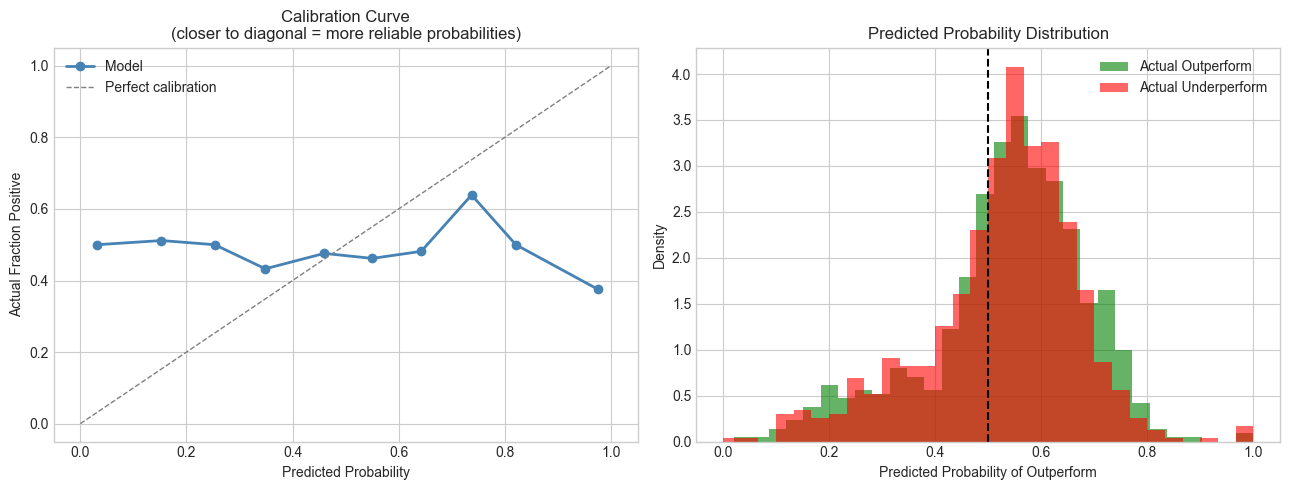

In [6]:
# ── Calibration Curve ──────────────────────────────────────────
test_mask = all_proba > 0
prob_true, prob_pred = calibration_curve(
    y[test_mask], all_proba[test_mask], n_bins=10
)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].plot(prob_pred, prob_true, 'o-', color='steelblue', linewidth=2, label='Model')
axes[0].plot([0, 1], [0, 1], '--', color='gray', linewidth=1, label='Perfect calibration')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Actual Fraction Positive')
axes[0].set_title('Calibration Curve\n(closer to diagonal = more reliable probabilities)')
axes[0].legend()

axes[1].hist(all_proba[test_mask & (y == 1)], bins=30, alpha=0.6,
             color='green', label='Actual Outperform', density=True)
axes[1].hist(all_proba[test_mask & (y == 0)], bins=30, alpha=0.6,
             color='red', label='Actual Underperform', density=True)
axes[1].axvline(0.5, color='black', linestyle='--')
axes[1].set_xlabel('Predicted Probability of Outperform')
axes[1].set_ylabel('Density')
axes[1].set_title('Predicted Probability Distribution')
axes[1].legend()

plt.tight_layout()
plt.savefig('../outputs/03_calibration.png', dpi=150, bbox_inches='tight')
plt.show()

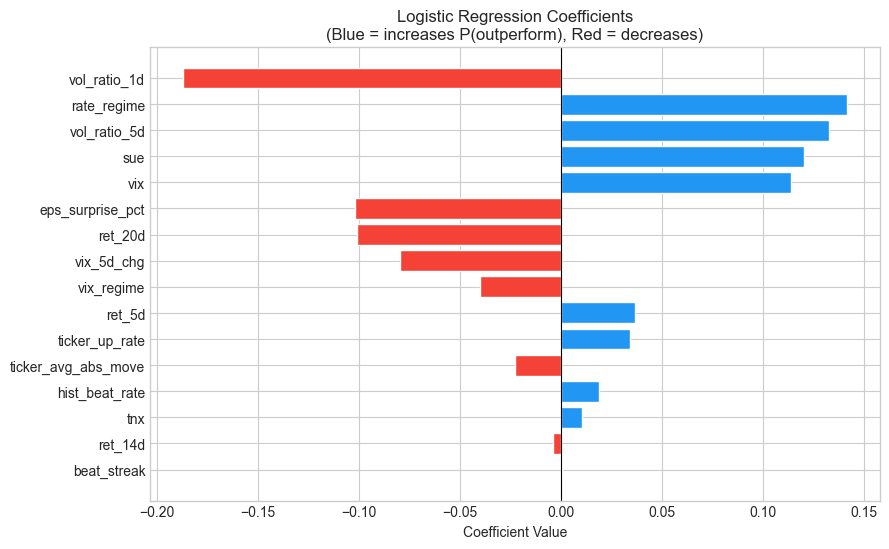

Key check: Is SUE coefficient positive? (It should be)


In [7]:
# ── Coefficient Plot ───────────────────────────────────────────
pipeline.fit(X, y)
coefs = pipeline.named_steps['model'].coef_[0]

coef_df = pd.DataFrame({
    'feature': LOGIT_FEATURES,
    'coef':    coefs
}).sort_values('coef', key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(9, max(5, len(coef_df)*0.35)))
colors = ['#2196F3' if c > 0 else '#F44336' for c in coef_df['coef']]
ax.barh(coef_df['feature'], coef_df['coef'], color=colors, edgecolor='white')
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('Coefficient Value')
ax.set_title('Logistic Regression Coefficients\n(Blue = increases P(outperform), Red = decreases)')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../outputs/03_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()
print('Key check: Is SUE coefficient positive? (It should be)')

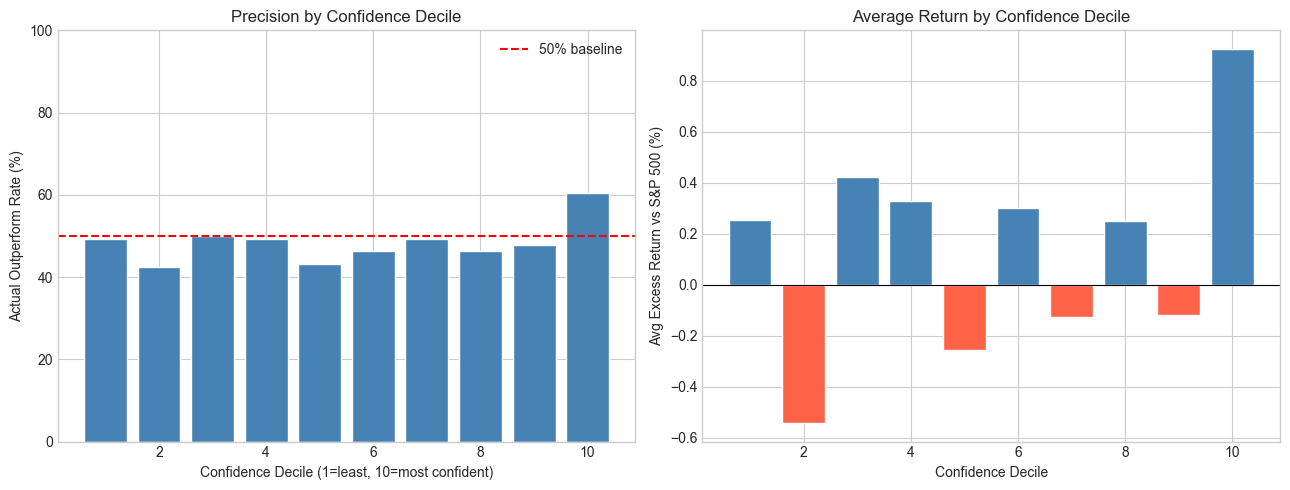

Top decile: 60.4% outperform rate, +0.92% avg excess return
Target: >60% outperform rate in top decile for a tradeable signal


In [8]:
# ── Top-Decile Precision ───────────────────────────────────────
df_model['proba']   = all_proba
df_model['pred']    = all_pred
df_model['in_test'] = (all_proba > 0).astype(int)

df_test = df_model[df_model['in_test'] == 1].copy()
df_test['confidence_decile'] = pd.qcut(
    df_test['proba'].rank(method='first'), q=10, labels=False
) + 1

decile_stats = df_test.groupby('confidence_decile').agg(
    actual_outperform_rate=('target_binary', 'mean'),
    avg_excess_ret=('excess_ret_5d', 'mean'),
    n_events=('target_binary', 'count')
).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].bar(decile_stats['confidence_decile'],
            decile_stats['actual_outperform_rate'] * 100,
            color='steelblue', edgecolor='white')
axes[0].axhline(50, color='red', linestyle='--', label='50% baseline')
axes[0].set_xlabel('Confidence Decile (1=least, 10=most confident)')
axes[0].set_ylabel('Actual Outperform Rate (%)')
axes[0].set_title('Precision by Confidence Decile')
axes[0].legend()
axes[0].set_ylim(0, 100)

axes[1].bar(decile_stats['confidence_decile'],
            decile_stats['avg_excess_ret'] * 100,
            color=['tomato' if v < 0 else 'steelblue'
                   for v in decile_stats['avg_excess_ret']],
            edgecolor='white')
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].set_xlabel('Confidence Decile')
axes[1].set_ylabel('Avg Excess Return vs S&P 500 (%)')
axes[1].set_title('Average Return by Confidence Decile')

plt.tight_layout()
plt.savefig('../outputs/03_decile_precision.png', dpi=150, bbox_inches='tight')
plt.show()

top = decile_stats[decile_stats['confidence_decile'] == 10].iloc[0]
print(f'Top decile: {top["actual_outperform_rate"]:.1%} outperform rate, '
      f'{top["avg_excess_ret"]*100:+.2f}% avg excess return')
print('Target: >60% outperform rate in top decile for a tradeable signal')

In [9]:
# ── Save predictions for backtest notebook ─────────────────────
df_model[['ticker', 'earn_date', 'target_binary', 'excess_ret_5d',
          'proba', 'pred']].to_csv(
    '../data/logit_predictions.csv', index=False
)
print('Predictions saved to data/logit_predictions.csv')

Predictions saved to data/logit_predictions.csv
